[![Open In colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/institutohumai/cursos-python/blob/master/DatosGeograficos/1_Introduccion/ejercicio/ejercicio-solucion.ipynb)

<h1 id="tocheading">Tabla de contenidos</h1>
<div id="toc"></div>

I. Tabla de contenidos

    I. Ejercicios
    II. Leemos y cargamos geometrías
    III. Pasamos todo a GKBA
    IV. Calculamos centroide y distancias
    V. Graficamos y comparamos
    VI. Barrio con mayor distancia a hospitales

## Ejercicios

Cuando uno realiza análisis urbanos es común intentar resumir la heterogeneidad de condiciones en pocas métricas, para poder entender cómo se fragmenta las ciudades con zonas de mayor o menor calidad de servicios, condiciones de vida, facilidad en circulación o conectividad, etc.

En este caso vamos a tratar de generar indicadores de accesibilidad por barrios para analizar:

- El acceso a la salud pública

- El acceso a los servicios de bomberos

1- Para ello, se propone calcular las siguientes métricas:

    a- Obtener el centroide para cada barrio.

    b- Medir la distancia de cada centroide a cada estación de bomberos (u hospital).
    
    c_1- Generamos la métrica "Distancia a hospitales":  entendiendo que a veces los hospitales pueden saturarse o tienen mayor diversidad de especializaciones (por ejemplo, hay hospitales especializados en niños o en problemas psiquiátricos) calculamos la distancia promedio a los 3 más cercanos. 
    c_2 - Generamos la métrica "Distancia a bomberos": en el caso de los bomberos se decide sólo tomar la distancia al más cercano.

Para que la métrica sea más interpretable debemos calcular la distancia en metros o kilómetros.

2- Luego analicemos los resultados. Para ello se propone:

    a- comparar un histograma de la distribución de la distancia a bomberos y a hospitales por barrios. Deberían encontrar que la distribución a los hospitales presenta "una cola más larga". Es decir, hay barrios que están relativamente más lejos.

    b- Finalmente, se pide que encuentren el barrio con mayor distancia a los hospitales y generen un mapa donde muestren en distintos colores:
    
    - Barrios
    
    - Hospitales
    
    - El barrio con mayor distancia

In [1]:
# !pip install geopandas

In [2]:
# !apt install libspatialindex-dev
# !pip install rtree

In [3]:
import pandas as pd
import geopandas
from shapely.geometry import Point
import shapely

In [4]:
def from_x_y(df, x, y, crs='EPSG:4326'):
    gdf = geopandas.GeoDataFrame(df.drop([x, y], axis=1), # eliminamos las columnas originales
                                crs=crs, # Agregamos CRS
                                geometry=geopandas.points_from_xy(df[x], df[y])) # junto "x" e "y" y lo paso a Point
    return gdf

In [5]:
def from_wkt(df, wkt_column, crs='EPSG:4326'):
    
    df["coordinates"]= df[wkt_column].apply(shapely.wkt.loads) # empleamos una función de shapely para leer WKT
        
    gdf = geopandas.GeoDataFrame(barrios, geometry='coordinates', crs=crs) # seteamos la columna de geometría
    
    return gdf

## Leemos y cargamos geometrías

In [6]:
hospitales = pd.read_csv("https://datasets-humai.s3.amazonaws.com/datasets/hospitales.csv")

In [7]:
hospitales = from_x_y(hospitales, "long", "lat")

In [8]:
bomberos = pd.read_csv("https://datasets-humai.s3.amazonaws.com/datasets/bomberos.csv")

In [9]:
bomberos = from_x_y(bomberos, "long","lat")

In [10]:
barrios = pd.read_csv("https://datasets-humai.s3.amazonaws.com/datasets/barrios.csv", encoding='latin1')

In [11]:
barrios = from_wkt(barrios, "WKT")

## Pasamos todo a GKBA

In [12]:
gkba_proj = "+proj=tmerc +lat_0=-34.629269 +lon_0=-58.4633 +k=0.9999980000000001 +x_0=100000 +y_0=100000 +ellps=intl +units=m +no_defs"

In [13]:
barrios_gkba = barrios.to_crs(crs = gkba_proj)

In [14]:
bomberos_gkba = bomberos.to_crs(crs = gkba_proj)

In [15]:
hospitales_gkba = hospitales.to_crs(crs = gkba_proj)

## Calculamos centroide y distancias

In [16]:
barrios_gkba["centroide"] = barrios_gkba.centroid

In [17]:
def promedio_a_punto(geometria, punto, n=1):
    return geometria.geometry.apply(lambda x: x.distance(punto)).nsmallest(n).mean()

In [18]:
barrios_gkba["dist_a_bomberos"] = barrios_gkba["centroide"].apply(lambda x: promedio_a_punto(bomberos_gkba, x))

In [19]:
barrios_gkba["dist_a_hospitales"] = barrios_gkba["centroide"].apply(lambda x: promedio_a_punto(hospitales_gkba, x, n=3))

## Graficamos y comparamos

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

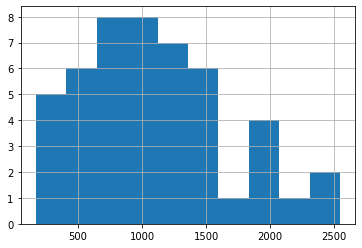

In [21]:
barrios_gkba["dist_a_bomberos"].hist()

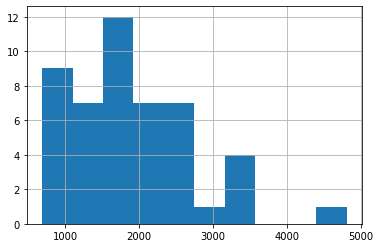

In [22]:
barrios_gkba["dist_a_hospitales"].hist()

## Barrio con mayor distancia a hospitales

In [23]:
barrios_gkba.loc[barrios_gkba["dist_a_hospitales"].idxmax()]

WKT                  POLYGON ((-58.4497832682116 -34.6806103119189,...
BARRIO                                                 VILLA RIACHUELO
COMUNA                                                               8
PERIMETRO                                                      10597.3
AREA                                                       4.23287e+06
coordinates          POLYGON ((101238.7450197537 94304.27703230902,...
centroide                   POINT (99995.4345033409 93056.51643583336)
dist_a_bomberos                                                1075.12
dist_a_hospitales                                              4809.03
Name: 34, dtype: object

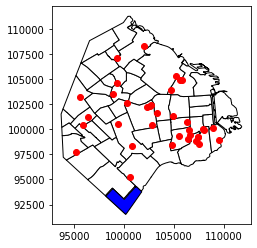

In [24]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
barrios_gkba.plot(ax=ax, color='white', edgecolor='black')
hospitales_gkba.plot(ax=ax, color='red')
barrios_gkba.query("BARRIO == 'VILLA RIACHUELO'").plot(ax=ax, color='blue', edgecolor='black')
plt.show();